<a href="https://colab.research.google.com/github/Thandazani/unsupervised-predict-streamlit-template/blob/master/Collaborative_Movie_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Collaborative Recommender System**

**Collaborative Filtering**

The idea behind collaborative filtering is to consider users’ opinions on different videos and recommend the best video to each user based on the user’s previous rankings and the opinion of other similar types of users.



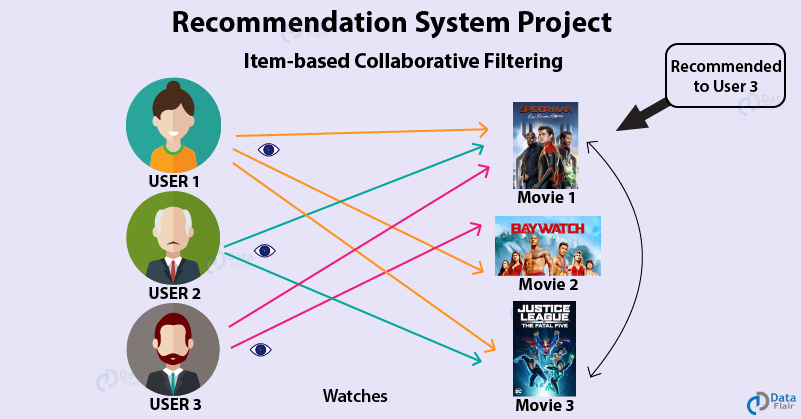

**Pros:**


> It does not need a movie’s side knowledge like genres.


> It uses information collected from other users to recommend new items to the current user.

Techniques of Collaborative Filtering:



*   User-based nearest neighbor.
*   Item-based nearest neighbor.

*   Reducing dimensionality.

But we will only Focus on User-Based nearest neighbor in our model.



*User-based Nearest Neighbor*

The basic technique of user-based Nearest Neighbor for the user John:
John is an active Netflix user and has not seen a video “v” yet. Here, the user-based nearest neighbor algorithm will work like below:
The technique finds a set of users or nearest neighbors who have liked the same items as John in the past and have rated video “v.”
Algorithm predicts.
Performs for all the items John has not seen and recommends.







In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 4.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630168 sha256=31e6c7aadfc62db5d5d6fe3dfc4b8f855c4b5dfa161193e5d930a5fc55d22de4
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import scipy as sp

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ML Models
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ML Pre processing
from surprise.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Hyperparameter tuning
from surprise.model_selection import GridSearchCV


# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/train.csv")
#dftest = pd.read_csv("/content/drive/MyDrive/test.csv")
#tags = pd.read_csv("/content/drive/MyDrive/tags.csv")
movies = pd.read_csv("/content/drive/MyDrive/movies.csv")
#links = pd.read_csv("/content/drive/MyDrive/links.csv")
#imdb = pd.read_csv("/content/drive/MyDrive/imdb_data.csv")
#genome_tags = pd.read_csv("/content/drive/MyDrive/genome_tags.csv")
#genome_scores = pd.read_csv("/content/drive/MyDrive/genome_scores.csv")

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


**COLLABORATIVE FILTERING**

Creating kNN Model
Selecting only 100000 rows from train dataset for ratings

After creating a new DF where we select only 100000 Dataset, now we creating a Pivot Table with users as indices and movies as columns

For the purpose of parsing data to our model later, we need to create a Pivot Table. For this, we set 'MovieId' as the index, our columns will be 'userId' and the values in our table will be 'rating'

In [ ]:
ratings = train.head(100000)
data = ratings.pivot(index='movieId',columns='userId',values='rating')
data.head()

userId,2,3,4,8,9,12,15,19,21,31,...,162514,162516,162517,162519,162521,162522,162529,162534,162535,162541
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.fillna(0,inplace=True)
data.head()

userId,2,3,4,8,9,12,15,19,21,31,...,162514,162516,162517,162519,162521,162522,162529,162534,162535,162541
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

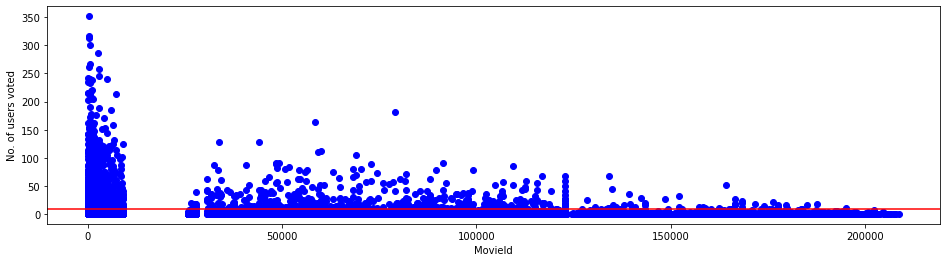

In [ ]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='blue')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

creating a threashold of 10 users where a minimum number of users voted for a movie



In [ ]:
data = data.loc[no_user_voted[no_user_voted > 10].index,:]

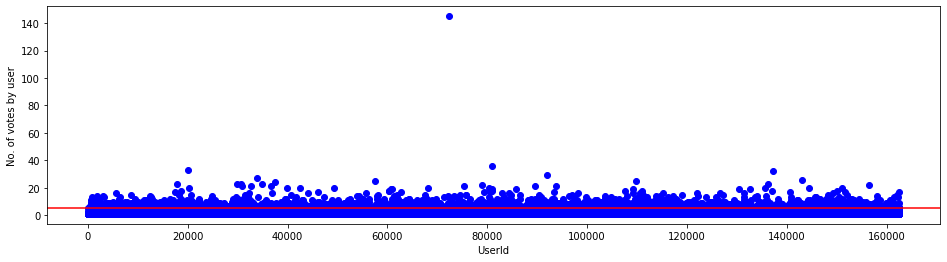

In [ ]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='blue')
plt.axhline(y=5,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

creating a threshold of 10 votes where a user voted for a certain movie to qualify.

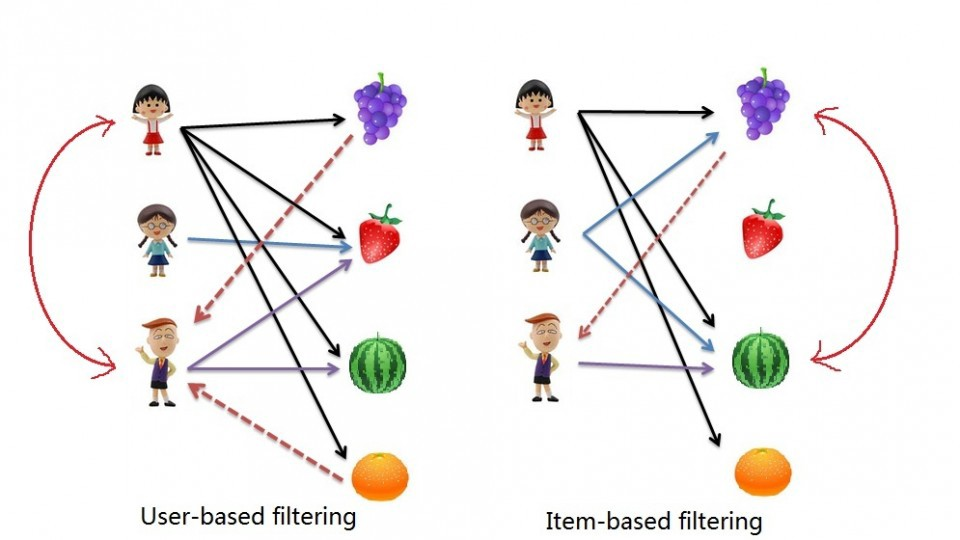

In [ ]:
data = data.loc[:,no_movies_voted[no_movies_voted > 10].index]
data

userId,626,847,1748,1920,1977,2177,2982,3150,5572,6285,...,154484,156480,158028,158109,158655,160747,161544,162047,162271,162516
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sample = np.array([[0,0,3,0,0],[4,0,0,0,2],[0,0,0,0,1]])
sparsity = 1.0 - ( np.count_nonzero(sample) / float(sample.size) )
print(sparsity)

0.7333333333333334


Creating a kNN model to print 10 movies recommendations similar to each other We use the csr_matrix from scipy.sparse to convert our pivot table into a matrix of arrays that we will use to fit our model.

In [ ]:
csr_sample = csr_matrix(sample)
print(csr_sample)

  (0, 2)	3
  (1, 0)	4
  (1, 4)	2
  (2, 4)	1


In [ ]:
csr_data = csr_matrix(data.values)
data.reset_index(inplace=True)

We use cosine distance metric which is very fast and preferable than pearson coefficient.

Finally, we fit the NearestNeighbors from sklearn.neighbors to our previously generated matrix data. We set the metric to 'cosine' and algorithm 'brute'.

In [ ]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [ ]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

The recommendation function The working principle is very simple. We first check if the movie name input is in the database and if it is we use our recommendation system to find similar movies and sort them based on their similarity distance and output only the top 10 movies according to their distances from the input movie

In [ ]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = data[data['movieId'] == movie_idx].index[0]
        
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),\
                               key=lambda x: x[1])[:0:-1]
        
        recommend_frame = []
        
        for val in rec_movie_indices:
            movie_idx = data.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    
    else:
        
        return "No movies found. Please check your input"

Testing the functionality of Collaborative Filtering Recommender System

In [ ]:
get_movie_recommendation('Avatar')

,Title,Distance
1,Minority Report (2002),1.000000
2,Insomnia (2002),1.000000
3,Spider-Man (2002),1.000000
4,Star Wars: Episode II - Attack of the Clones (...,1.000000
5,About a Boy (2002),1.000000
6,"Bourne Identity, The (2002)",1.000000
7,Wes Craven's New Nightmare (Nightmare on Elm S...,0.418762
8,"Time Machine, The (2002)",0.292893
9,Howard the Duck (1986),0.269703
10,Scary Movie (2000),0.080855


In [ ]:
get_movie_recommendation('About a Boy')

,Title,Distance
1,Mr. Deeds (2002),1.0
2,Minority Report (2002),1.0
3,Lilo & Stitch (2002),1.0
4,Frailty (2001),1.0
5,Star Wars: Episode II - Attack of the Clones (...,1.0
6,About a Boy (2002),1.0
7,Unfaithful (2002),1.0
8,Spider-Man (2002),1.0
9,The Scorpion King (2002),1.0
10,"Sum of All Fears, The (2002)",1.0


o conclude the system, it appears that our algorithm worked as expected, as we can see our movies in descending order according to their distances and how close they are to the selected movie, thats how our collaborative make a recommendation to the user.